These are the imports we'll be needing for this project

In [0]:
#import statements
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup as bsoup
import folium
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cmx
import matplotlib.colors as colors

These login details will not be available, limit can be changed to 100 without much impact

In [0]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''
ACCESS_TOKEN = ''
LIMIT = 10000

This is where we get the request for all Chinese restaurants within 50km of the centroid of Singapore

In [3]:
latitude = 1.3521
longitude = 103.8198
print(latitude, longitude)

1.3521 103.8198


In [4]:
search_query = 'Chinese Restaurant'
radius = 50000
print(search_query + ' .... OK!')

Chinese Restaurant .... OK!


In [5]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=TBX20G2X4ACQ55MQKPXQRQWTZAODLUFP33IIQJKFG4NBUYYV&client_secret=HIOAP5DW3N3EH0SBXEYLZJ10E3EVNIHGPMZMWVHTPIDGZTBH&ll=1.3521,103.8198&v=20180605&query=Chinese Restaurant&radius=50000&limit=10000'

In [0]:
results = requests.get(url).json()

We need to clean the data and remove all cases where the country isn't Singapore, and in the one case where a school orchestra place is listed as a restaurant

In [7]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df = pd.json_normalize(venues)
for i, j in df.iterrows():
  temp = "Singapore"
  if (j['location.country'] != temp):
    df = df.drop([i])
  if (j['id'] == '4d88629b99c2a1cd33bf65d7'):
    df = df.drop([i])
df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.country,location.formattedAddress,location.postalCode,location.neighborhood,location.state,venuePage.id
0,4d1eb3ed16cfb60c807e4b61,The Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1589560834,False,Raffles Town Club,1 Plymouth Avenue,1.321757,103.825033,"[{'label': 'display', 'lat': 1.321757186367034...",3427,SG,Singapore,Singapore,"[Raffles Town Club (1 Plymouth Avenue), Singap...",NaN,NaN,NaN,NaN
1,4c6165973986e21ea472964f,Dong Fang Mei Shi Fan Dian 东方美食饭店 (Oriental Ch...,"[{'id': '52af3a9f3cf9994f4e043bef', 'name': 'D...",v-1589560834,False,195 New Bridge Road,NaN,1.284209,103.843685,"[{'label': 'display', 'lat': 1.284209239328939...",8011,SG,Singapore,Singapore,"[195 New Bridge Road, 059425, Singapore]",059425,Chinatown,NaN,NaN
2,4d47e3af847e6dcb176398c4,Wan Hao Chinese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1589560834,False,"Level 3, Marriott Singapore Tang Plaza",320 Orchard Rd.,1.305004,103.832916,"[{'label': 'display', 'lat': 1.305004, 'lng': ...",5442,SG,Singapore,Singapore,"[Level 3, Marriott Singapore Tang Plaza (320 O...",238865,NaN,NaN,NaN
3,4bab5c81f964a52061a33ae3,Guan Kitchen Chinese Restaurant 壮元府传统美食,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1589560834,False,221 River Valley Rd.,NaN,1.293827,103.842424,"[{'label': 'display', 'lat': 1.293827469570317...",6958,SG,Singapore,Singapore,"[221 River Valley Rd., Singapore]",NaN,NaN,NaN,NaN
4,4daac6cfcda1652a2b943b71,Yang Gui Fei Chinese Restaurant 羊貴妃,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1589560834,False,18 Smith Street,NaN,1.282152,103.844470,"[{'label': 'display', 'lat': 1.282152020989047...",8256,SG,Singapore,Singapore,"[18 Smith Street, Singapore]",NaN,NaN,NaN,NaN


This function is hardcoded to get the district of a place based on the first two numbers of the postal code (assuming that the first two numbers are passed in). Another method, especially for larger datasets, would be to use a direct address table

In [0]:
def get_district(code):
  i = int(code)
  if (i<=6):
    return 1
  elif (i == 7 or i == 8):
    return 2
  elif (i>=14 and i<=16):
    return 3
  elif (i>=9 and i<=10):
    return 4
  elif (i>=11 and i<=13):
    return 5
  elif (i== 17):
    return 6
  elif (i>=18 and i<=19):
    return 7
  elif (i>=20 and i<=21):
    return 8
  elif (i>=22 and i<=23):
    return 9
  elif (i>=24 and i<=27):
    return 10
  elif (i>=28 and i<=30):
    return 11
  elif (i>=31 and i<=33):
    return 12
  elif (i>=34 and i<=37):
    return 13
  elif (i>=38 and i<=41):
    return 14
  elif (i>=42 and i<=45):
    return 15
  elif (i>=46 and i<=48):
    return 16
  elif (i>=49 and i<=50 or i == 81):
    return 17
  elif (i>=51 and i<=52):
    return 18
  elif (i>=53 and i<=55 or i == 82):
    return 19
  elif (i>=56 and i<=57):
    return 20
  elif (i>=58 and i<=59):
    return 21
  elif (i>=60 and i<=64):
    return 22
  elif (i>=65 and i<=68):
    return 23
  elif (i>=69 and i<=71):
    return 24
  elif (i>=72 and i<=73):
    return 25
  elif (i>=77 and i<=78):
    return 26
  elif (i>=75 and i<=76):
    return 27
  elif (i>=79 and i<=80):
    return 28
  else:
    return 0

We iterate through the addresses and get the districts. In the three cases where the postal code isn't available, we just manually populate the postal code

In [0]:
lst = []
for i, j in df.iterrows():
  lat = j['location.lat']
  lng = j['location.lng']
  geolocator = Nominatim(user_agent="capstone")
  location = geolocator.reverse(str(lat) + ", " + str(lng))
  if ('postcode' in location.raw['address']):
    postcode = location.raw['address']['postcode']
    if (len(postcode) == 5):
      postcode = "0" + postcode
    #print(str(i) + ", " + str(get_district(postcode[0:2])))
    lst.append(get_district(postcode[0:2]))
  else:
    place_id = location.raw['place_id']
    if (place_id == 114548700):
      postcode = "038983"
    elif (place_id == 192025562):
      postcode = "180008"
    elif (place_id == 236542830):
      postcode = "238360"
    #print(str(i) + ", " + str(get_district(postcode[0:2])))
    lst.append(get_district(postcode[0:2]))

In [10]:
len(lst)


38

Adding the district values to the dataframe

In [0]:
df['district'] = lst

In [0]:
df = df[['name','location.lat','location.lng','district']]

Here, we count how many restaurants are in each districts. As you can see from df1, many districts do not even contain one restaurant

In [0]:
df1 = df['district'].value_counts().to_frame()
df1.rename(columns = {'district' : 'count'}, inplace=True)
df1.columns.name = 'district'

In [14]:
df1

district,count
1,11
9,4
22,3
12,3
7,3
23,2
20,2
19,2
15,2
27,1


Now, we can draw the bar graph for the number of Chinese restaurants per district

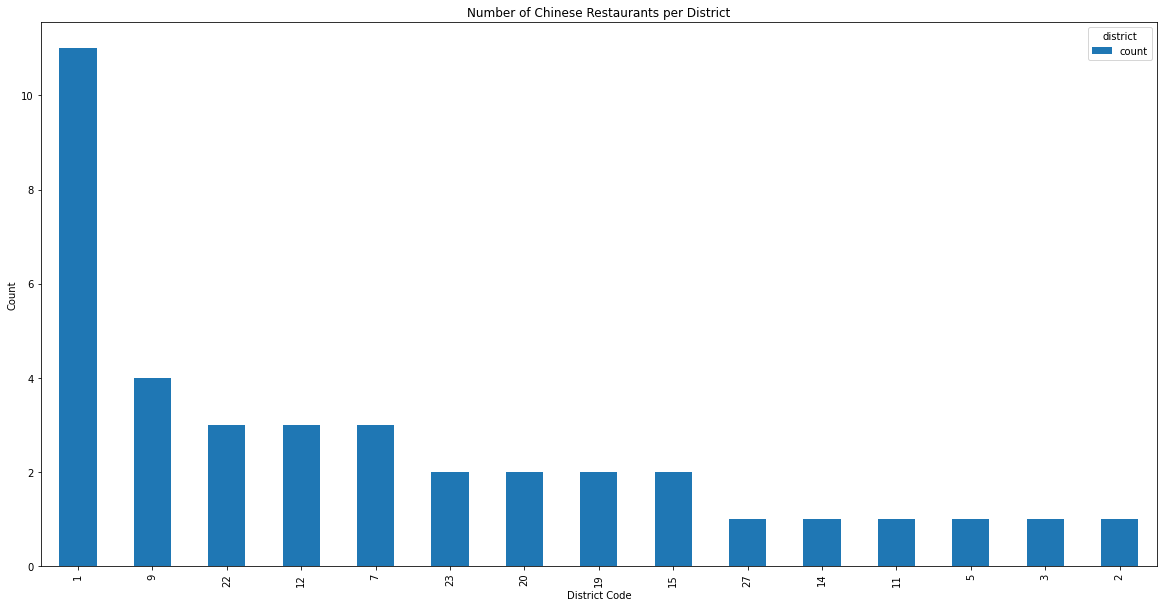

In [15]:
ax = df1.plot(kind = 'bar',figsize = (20,10), title = 'Number of Chinese Restaurants per District')
ax.set(xlabel = 'District Code',ylabel = 'Count')
ax

Next, we draw a map of all the restaurants

In [23]:
latitude = 1.41
longitude = 103.8198
sg = folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lng, name in zip(df['location.lat'], df['location.lng'], df['name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7,
        parse_html=False).add_to(sg)  
    
sg

Now, we create coordinates in preparation for using DBSCAN

In [0]:
df1 = df[['location.lat','location.lng']].copy()
coords = df1.to_numpy()

The code below clusters the restaurants based on DBSCAN. Note that we don't need the restaurant names here.

In [0]:
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian
db = DBSCAN(eps = epsilon, min_samples = 2).fit(np.radians(coords))
cluster_labels = db.labels_
n_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n]for n in range(-1, n_clusters)])

In [33]:
clusters

0    [[1.3217571863670343, 103.82503318226446], [1....
1    [[1.2842092393289395, 103.84368538856506], [1....
2    [[1.3034227, 103.904594], [1.302566, 103.905128]]
3                                                   []
dtype: object

The two functions below set the border color and fill color for the marker, respectively

In [0]:
def get_color(n):
  if (n == 0):
    return 'black'
  if (n == 1):
    return 'red'
  if (n == 2):
    return 'blue'
  if (n == 3):
    return 'orange'
  if (n == 4):
    return 'purple'
  if (n == 5):
    return 'cyan'

In [0]:
def get_fill(n):
  if (n == 0):
    return 'grey'
  if (n == 1):
    return 'orange'
  if (n == 2):
    return 'cyan'
  if (n == 3):
    return 'yellow'
  if (n == 4):
    return 'deeppink'
  if (n == 5):
    return 'white'

This code creates the map with the markers.

In [36]:
smap = folium.Map(location = [latitude, longitude], zoom_start = 13)
for i, j in enumerate(clusters):
  for k in j:
    print(str(i) + ", " + str(k[0]) + ", " + str(k[1]))
    color = get_color(i)
    lat = k[0]
    lng = k[1]
    fill_color = get_fill(i)
    folium.CircleMarker([lat,lng],radius = 10, color = color, fill = True, fill_color = fill_color, fill_opacity = 0.5, parse_html=False).add_to(smap)
smap

0, 1.3217571863670343, 103.82503318226446
0, 1.305004, 103.832916
0, 1.351757, 103.863468
0, 1.3404378977363178, 103.84721671200596
0, 1.326787, 103.847478
0, 1.320461, 103.863248
0, 1.3142859082610292, 103.8873103407875
0, 1.302502, 103.764545
0, 1.346764, 103.743379
0, 1.4293725569435694, 103.83646488189697
0, 1.384173578230099, 103.73672581527235
0, 1.328725114118995, 103.73741814113846
0, 1.338739, 103.705303
0, 1.3524185849536412, 103.87953009845229
0, 1.3772140756089977, 103.82804389947383
0, 1.3425036845731033, 103.73270381231949
0, 1.352747359128513, 103.83529967599257
1, 1.2842092393289395, 103.84368538856506
1, 1.293827469570317, 103.84242359859782
1, 1.2821520209890473, 103.84446966835456
1, 1.2825214049749114, 103.84864909125106
1, 1.2891362380546174, 103.84488983562346
1, 1.2897835478713977, 103.83653926177655
1, 1.291145, 103.845801
1, 1.2977582321225103, 103.85668317019133
1, 1.284522, 103.843916
1, 1.297628, 103.851998
1, 1.2971779535735608, 103.85766266981054
1, 1.2843